In [1]:
from common import colors

In [2]:
import os; os.chdir(os.path.join('..', '..', '..'))
print(os.getcwd())

/Users/eharkin/Documents/projects/5HTGIF


In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import pandas as pd
import seaborn as sns
from scipy import stats

import ezephys.rectools as rt
from ezephys import pltools
from grr.Trace import Trace
from grr.Tools import getIndicesByPercentile, timeToIndex

# Setup

In [4]:
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'fI')
DATA_PATH = os.path.join('data', 'raw')
NOTEBOOK_PATH = os.path.join('figs', 'scripts', 'writeup')

plt.style.use(os.path.join(NOTEBOOK_PATH, 'publication_figure_style.dms'))

# Load data

In [5]:
loader = rt.ABFLoader()

# Short current step recordings.
short_fnames = {}
short_recs = {}
for cell_type in ['5HT', 'GABA', 'mPFC']:
    short_fnames[cell_type] = pd.read_csv(os.path.join(DATA_PATH, cell_type, 'current_steps', 'index.csv'))
    short_recs[cell_type] = loader.load(
        [os.path.join(DATA_PATH, cell_type, 'current_steps', fname_) for fname_ in short_fnames[cell_type]['Steps']]
    )

# Long current step recordings.
long_fnames = {}
long_recs = {}
for cell_type in ['5HT', 'GABA']:
    long_fnames[cell_type] = pd.read_csv(os.path.join(DATA_PATH, cell_type, 'long_curr_steps', 'index.csv'))
    long_recs[cell_type] = loader.load(
        [
            os.path.join(DATA_PATH, cell_type, 'long_curr_steps', fname_) 
            for fname_ in long_fnames[cell_type]['weak_steps']
            if isinstance(fname_, str)
        ]
    )

In [6]:
short_fnames['5HT']

,Cell,R,C,hold,Steps
0,DRN159,707,43,-11.0,17n23013.abf
1,DRN160,365,79,-9.8,17n23017.abf
2,DRN162,485,57,-17.1,17n23022.abf
3,DRN163,1400,61,2.4,17n23027.abf
4,DRN164,919,39,-27.0,17n23034.abf
5,DRN165,759,63,-14.6,17n23038.abf
6,DRN196,923,74,-6.0,18111055.abf
7,DRN316,1200,40,-8.5,18420001.abf
8,DRN317,743,93,3.7,18420006.abf
9,DRN318,702,51,-8.0,18420025.abf


In [7]:
short_fnames['GABA']

,Cell,R,C,hold,Steps
0,DRN350,1700,42.0,-0.6,18711000.abf
1,DRN351,1600,38.0,-7.3,18711018.abf
2,DRN354,831,59.0,-8.5,18711033.abf
3,DRN355,960,36.0,-20.0,18711046.abf
4,DRN356,564,50.5,-5.5,18711060.abf
5,DRN357,552,55.0,-7.3,18711076.abf
6,DRN358,1200,38.0,10.0,18711091.abf
7,DRN421,836,71.0,-11.0,19114005.abf
8,DRN422,1400,57.0,13.4,19114022.abf
9,DRN424,1400,32.0,-9.8,19114045.abf


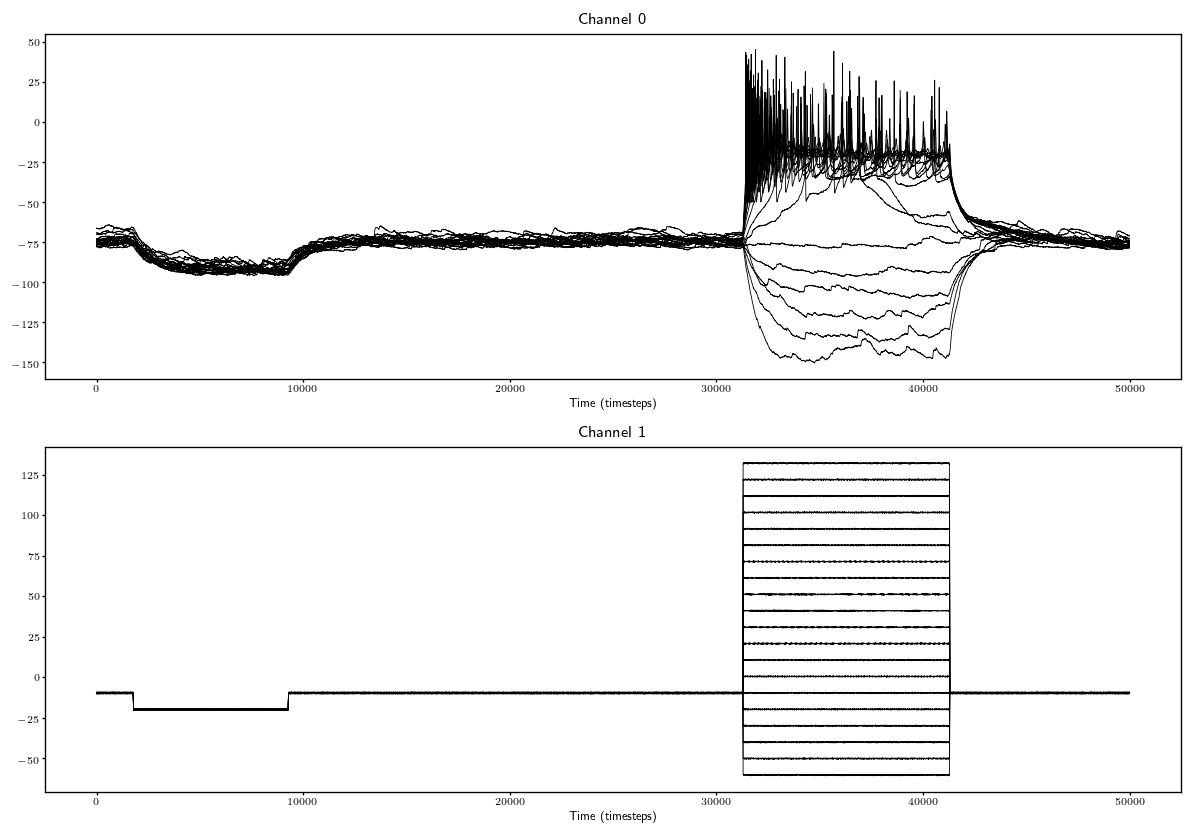

In [8]:
short_recs['GABA'][0].plot()

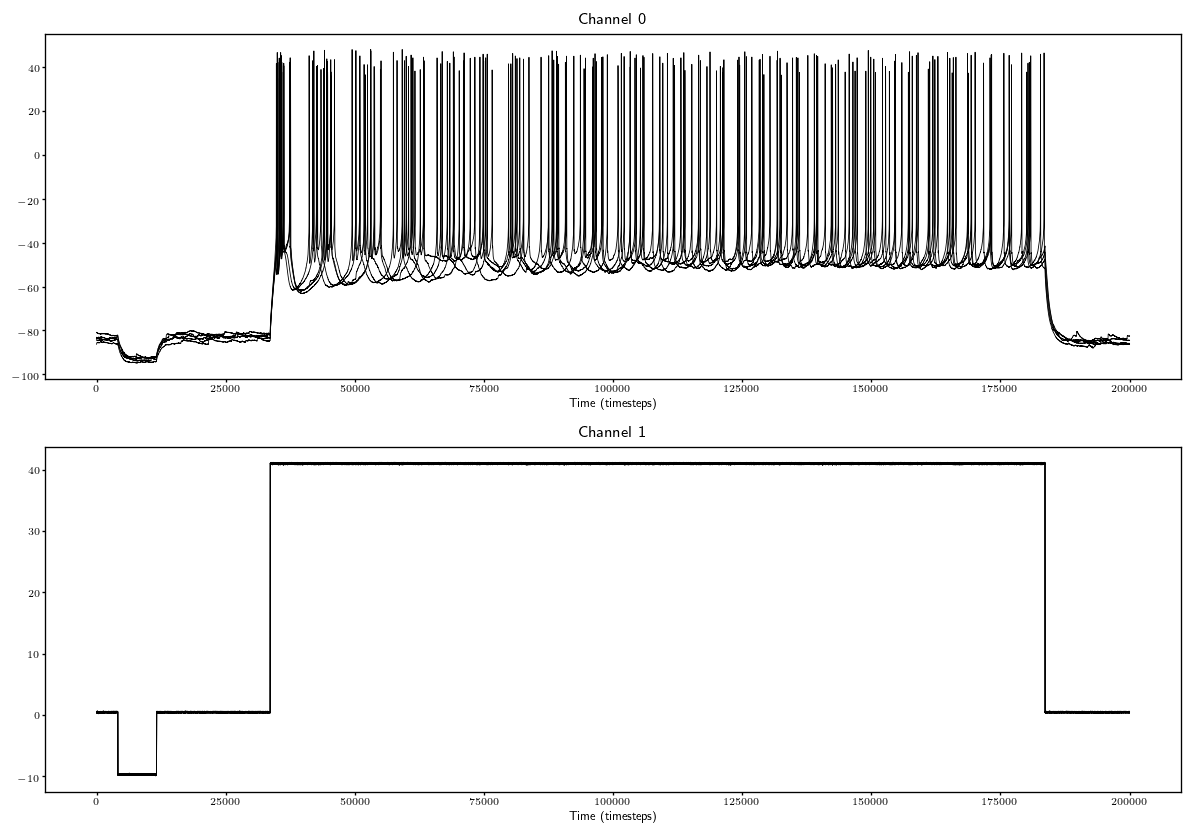

In [9]:
long_recs['5HT'][0].plot()

# Membrane parameters

Find test pulse range.

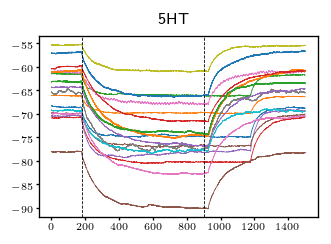

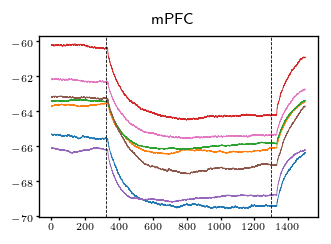

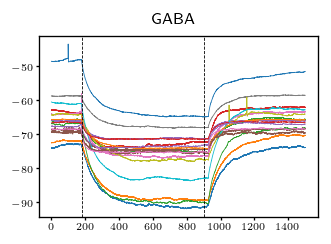

In [10]:
test_pulse_intervals = {
    '5HT': (180., 900.),
    'GABA': (180., 900.),
    'mPFC': (320., 1300.)
}
for cell_type in short_recs:
    plt.figure()
    plt.suptitle(cell_type)
    for i in range(len(short_recs[cell_type])):
        plt.plot(short_recs[cell_type][i].time_supp[:15000], short_recs[cell_type][i].mean(axis=2)[0, :15000])
    plt.axvline(test_pulse_intervals[cell_type][0], ls='--')
    plt.axvline(test_pulse_intervals[cell_type][1], ls='--')
    plt.show()

In [11]:
short_recs[cell_type][i].no_timesteps

50000

Fit test pulse.

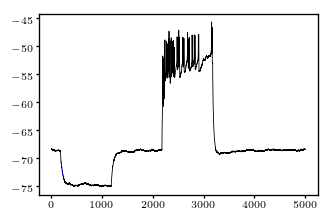



### Test-pulse results ###
R_in: 601.8 +/- 52.0 MOhm


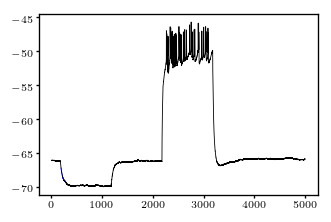



### Test-pulse results ###
R_in: 375.3 +/- 44.0 MOhm


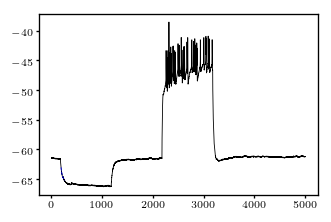



### Test-pulse results ###
R_in: 467.2 +/- 42.0 MOhm


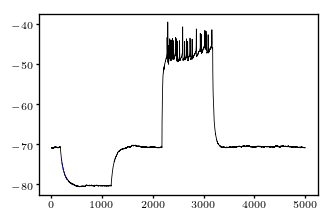



### Test-pulse results ###
R_in: 974.7 +/- 73.0 MOhm


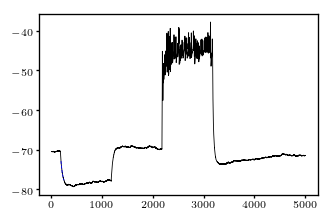



### Test-pulse results ###
R_in: 742.9 +/- 100.0 MOhm


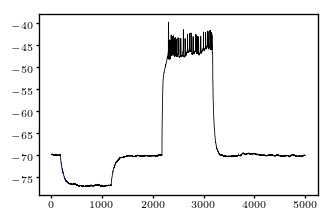



### Test-pulse results ###
R_in: 708.3 +/- 105.0 MOhm


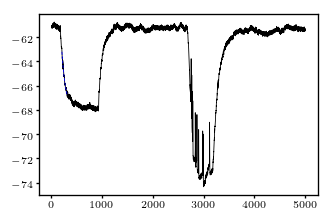



### Test-pulse results ###
R_in: 699.4 +/- 63.0 MOhm


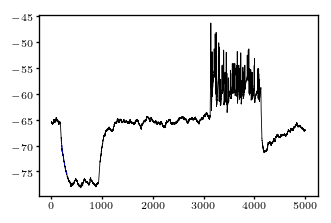



### Test-pulse results ###
R_in: 1192.6 +/- 253.0 MOhm


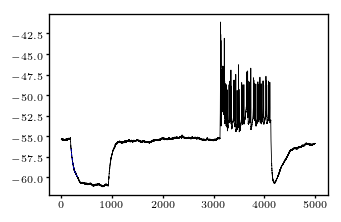



### Test-pulse results ###
R_in: 559.9 +/- 115.0 MOhm


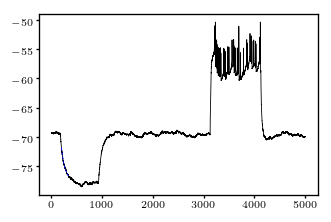



### Test-pulse results ###
R_in: 840.9 +/- 237.0 MOhm


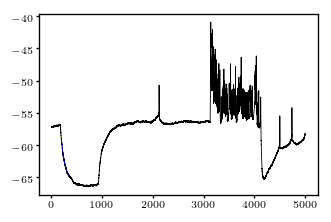



### Test-pulse results ###
R_in: 916.2 +/- 76.0 MOhm


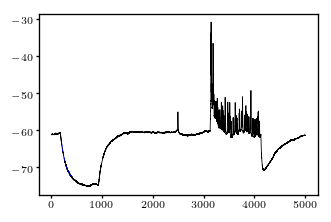



### Test-pulse results ###
R_in: 1353.3 +/- 321.0 MOhm


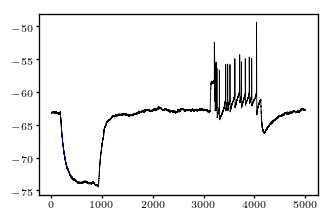



### Test-pulse results ###
R_in: 1074.5 +/- 109.0 MOhm


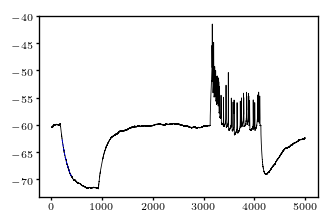



### Test-pulse results ###
R_in: 1140.0 +/- 160.0 MOhm


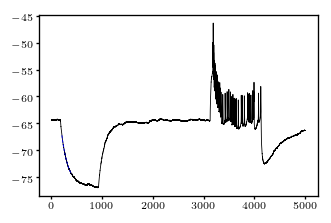



### Test-pulse results ###
R_in: 1233.6 +/- 142.0 MOhm


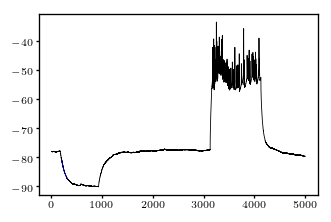



### Test-pulse results ###
R_in: 1192.6 +/- 283.0 MOhm


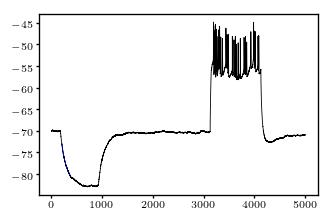



### Test-pulse results ###
R_in: 1278.1 +/- 132.0 MOhm


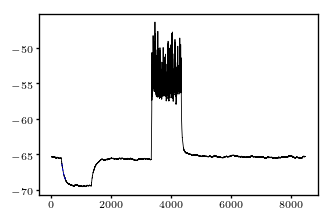



### Test-pulse results ###
R_in: 377.5 +/- 52.0 MOhm


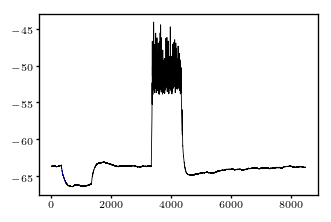



### Test-pulse results ###
R_in: 261.1 +/- 52.0 MOhm


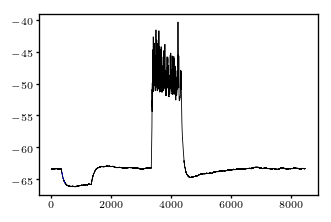



### Test-pulse results ###
R_in: 245.7 +/- 54.0 MOhm


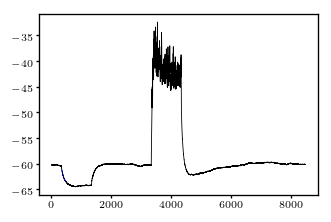



### Test-pulse results ###
R_in: 381.6 +/- 106.0 MOhm


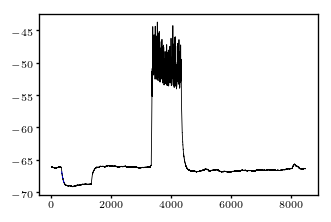



### Test-pulse results ###
R_in: 272.9 +/- 51.0 MOhm


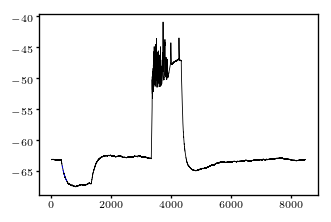



### Test-pulse results ###
R_in: 391.2 +/- 55.0 MOhm


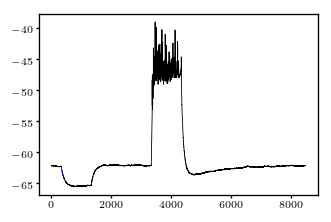



### Test-pulse results ###
R_in: 317.6 +/- 58.0 MOhm


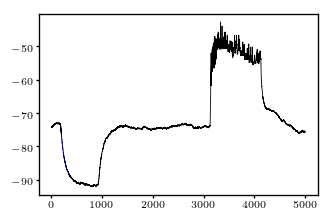



### Test-pulse results ###
R_in: 1832.8 +/- 367.0 MOhm


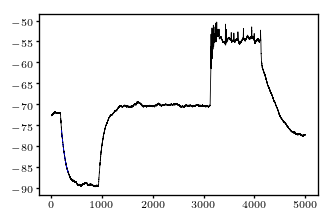



### Test-pulse results ###
R_in: 1725.4 +/- 231.0 MOhm


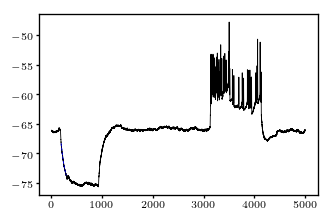



### Test-pulse results ###
R_in: 907.6 +/- 103.0 MOhm


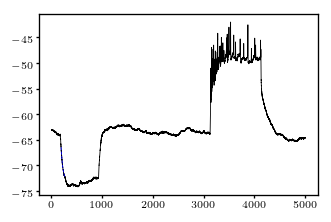



### Test-pulse results ###
R_in: 889.0 +/- 258.0 MOhm


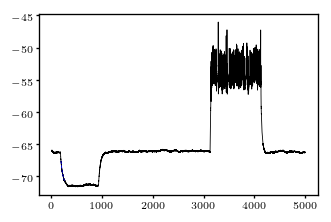



### Test-pulse results ###
R_in: 511.0 +/- 41.0 MOhm


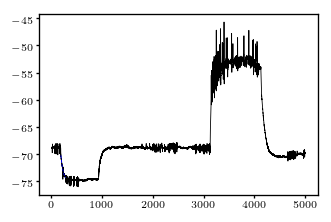



### Test-pulse results ###
R_in: 577.5 +/- 55.0 MOhm


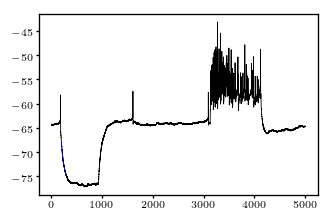



### Test-pulse results ###
R_in: 1239.6 +/- 124.0 MOhm


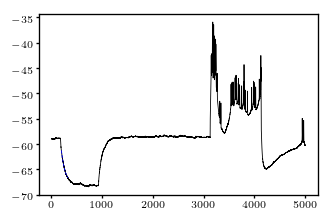



### Test-pulse results ###
R_in: 918.9 +/- 66.0 MOhm


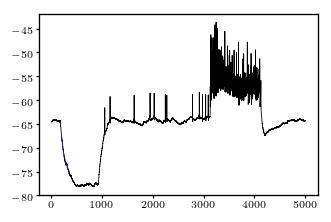



### Test-pulse results ###
R_in: 1341.8 +/- 203.0 MOhm


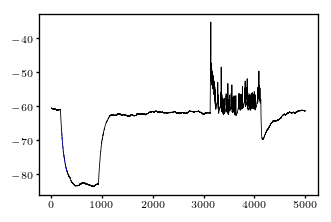



### Test-pulse results ###
R_in: 2226.9 +/- 400.0 MOhm


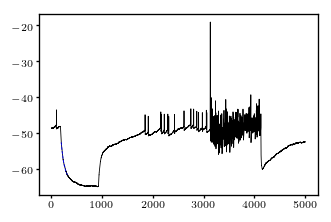



### Test-pulse results ###
R_in: 1632.9 +/- 331.0 MOhm


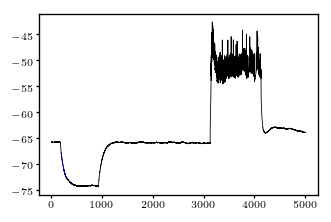



### Test-pulse results ###
R_in: 840.6 +/- 56.0 MOhm


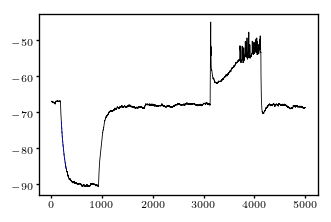



### Test-pulse results ###
R_in: 2285.8 +/- 263.0 MOhm


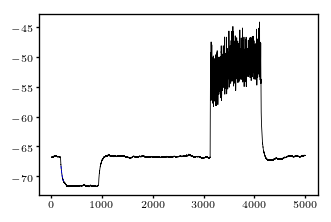



### Test-pulse results ###
R_in: 488.8 +/- 50.0 MOhm


/miniconda3/envs/neopozz/lib/python2.7/site-packages/ezephys/rectools.py:347: RuntimeWarning: divide by zero encountered in true_divide
  R_input = 1000 * delta_V_ss / delta_I_ss


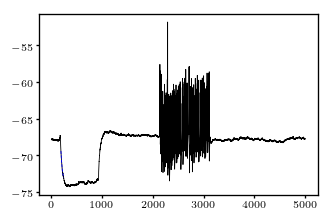



### Test-pulse results ###
R_in: -inf +/- nan MOhm


/miniconda3/envs/neopozz/lib/python2.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


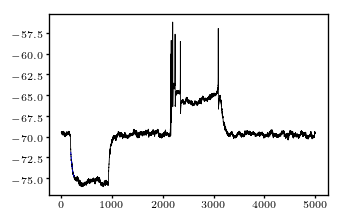



### Test-pulse results ###
R_in: -inf +/- nan MOhm


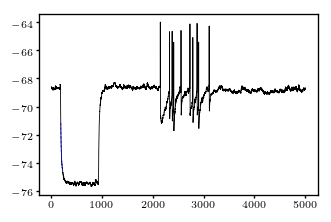



### Test-pulse results ###
R_in: 671.1 +/- 44.0 MOhm


In [12]:
membrane_params = {}
for cell_type in short_recs:
    membrane_params[cell_type] = pd.DataFrame()
    for i in range(len(short_recs[cell_type])):
        test_pulse_start_ind, test_pulse_end_ind = timeToIndex(
            test_pulse_intervals[cell_type], 
            short_recs[cell_type][i].dt
        )
        
        tau_limits = getIndicesByPercentile(
            short_recs[cell_type][i][0, test_pulse_start_ind:test_pulse_end_ind, :].mean(axis=1), 
            [.8, .2]
        )
        
        tmp_params = short_recs[cell_type][i].fit_test_pulse(
            (0, timeToIndex(test_pulse_intervals[cell_type][0], short_recs[cell_type][i].dt)[0]), 
            (test_pulse_end_ind - 1000, test_pulse_end_ind), 
            tau=(test_pulse_start_ind, tau_limits[0] + test_pulse_start_ind, tau_limits[1] + test_pulse_start_ind),
            V_clamp=False,
            V_chan=0,
            I_chan=1,
            plot_tau=True
        )
        tmp_params['R_input'] = np.mean(tmp_params['R_input'])  # Average R_in across sweeps.
        membrane_params[cell_type] = membrane_params[cell_type].append(tmp_params, ignore_index=True)
    
    membrane_params[cell_type] = membrane_params[cell_type].astype(np.float64)

Extracted parameters. R_input is in MOhm and tau is in ms. Note that some recordings have non-finite R_in, probably due to missing current channel.

In [13]:
membrane_params['5HT']

,R_input,tau
0,601.801604,58.211459
1,375.260825,33.652228
2,467.175715,30.057247
3,974.679520,69.716900
4,742.869758,39.610010
5,708.294680,78.999923
6,699.445178,76.446131
7,1192.630289,109.196596
8,559.868786,54.064363
9,840.866611,73.793339


In [14]:
membrane_params['5HT'].mean()

R_input    903.010019
tau         81.567163
dtype: float64

In [15]:
membrane_params['5HT'].sem()

R_input    74.190588
tau         8.347398
dtype: float64

In [16]:
membrane_params['GABA']

,R_input,tau
0,1832.835081,78.830090
1,1725.372531,102.845330
2,907.640624,90.213576
3,889.013307,39.113562
4,510.991251,42.118491
5,577.501016,46.390836
6,1239.566300,56.203347
7,918.904115,81.395212
8,1341.816482,77.956295
9,2226.853671,68.124219


In [17]:
print(membrane_params['GABA'].loc[np.isfinite(membrane_params['GABA']['R_input']), :].mean())
print('N = {}'.format(sum(np.isfinite(membrane_params['GABA']['R_input']))))

R_input    1205.981600
tau          62.452118
dtype: float64
N = 15


In [18]:
membrane_params['GABA'].loc[np.isfinite(membrane_params['GABA']['R_input']), :].sem()

R_input    156.702339
tau          6.303066
dtype: float64

In [19]:
membrane_params['mPFC']

,R_input,tau
0,377.526117,98.933202
1,261.103815,144.420557
2,245.710269,80.195173
3,381.596061,89.270893
4,272.885862,67.135465
5,391.225353,136.806608
6,317.590041,105.219738


## Compare membrane parameters between cell types

In [20]:
result = stats.mannwhitneyu(
    membrane_params['5HT']['R_input'], 
    membrane_params['GABA'].loc[np.isfinite(membrane_params['GABA']['R_input']), 'R_input'],
    alternative='two-sided'
)
print(result)
print('Bonferroni-corrected p_value: {:.4f}'.format(result.pvalue * 3))

MannwhitneyuResult(statistic=96.0, pvalue=0.24174145559381988)
Bonferroni-corrected p_value: 0.7252


In [21]:
result = stats.mannwhitneyu(
    membrane_params['5HT']['R_input'], 
    membrane_params['mPFC']['R_input'],
    alternative='two-sided'
)
print(result)
print('Bonferroni-corrected p_value: {:.4f}'.format(result.pvalue * 3))

MannwhitneyuResult(statistic=116.0, pvalue=0.0003756838651438534)
Bonferroni-corrected p_value: 0.0011


In [22]:
result = stats.mannwhitneyu(
    membrane_params['GABA'].loc[np.isfinite(membrane_params['GABA']['R_input']), 'R_input'], 
    membrane_params['mPFC']['R_input'],
    alternative='two-sided'
)
print(result)
print('Bonferroni-corrected p_value: {:.4f}'.format(result.pvalue * 3))

MannwhitneyuResult(statistic=105.0, pvalue=0.00024683810135600604)
Bonferroni-corrected p_value: 0.0007


In [23]:
result = stats.mannwhitneyu(
    membrane_params['5HT']['tau'], 
    membrane_params['GABA'].loc[np.isfinite(membrane_params['GABA']['R_input']), 'tau'],
    alternative='two-sided'
)
print(result)
print('Bonferroni-corrected p_value: {:.4f}'.format(result.pvalue * 3))

MannwhitneyuResult(statistic=172.0, pvalue=0.09660086735923616)
Bonferroni-corrected p_value: 0.2898


In [24]:
result = stats.mannwhitneyu(
    membrane_params['5HT']['tau'], 
    membrane_params['mPFC']['tau'],
    alternative='two-sided'
)
print(result)
print('Bonferroni-corrected p_value: {:.4f}'.format(result.pvalue * 3))

MannwhitneyuResult(statistic=38.0, pvalue=0.18229385662815656)
Bonferroni-corrected p_value: 0.5469


In [25]:
result = stats.mannwhitneyu(
    membrane_params['mPFC']['tau'], 
    membrane_params['GABA'].loc[np.isfinite(membrane_params['GABA']['R_input']), 'tau'],
    alternative='two-sided'
)
print(result)
print('Bonferroni-corrected p_value: {:.4f}'.format(result.pvalue * 3))

MannwhitneyuResult(statistic=91.0, pvalue=0.007392004955599255)
Bonferroni-corrected p_value: 0.0222


## Export membrane parameter plots

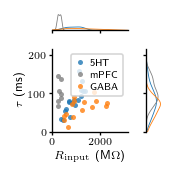

In [26]:
joint_spec = gs.GridSpec(2, 2, height_ratios=[0.2, 1], width_ratios=[1, 0.2])

plt.figure(figsize=(1.5, 1.5))

joint_ax = plt.subplot(joint_spec[1, 0])
x_dist_ax = plt.subplot(joint_spec[0, 0])
y_dist_ax = plt.subplot(joint_spec[1, 1])

for i, cell_type in enumerate(membrane_params):
    if cell_type == '5HT':
        color = colors['ser']
    elif cell_type == 'GABA':
        color = colors['som']
    elif cell_type == 'mPFC':
        color = colors['pyr']
    else:
        raise RuntimeError('Unrecognized cell type {}'.format(cell_type))
    
    mask = np.isfinite(membrane_params[cell_type]['R_input'])
    alpha = 0.7 if i != 0 else 1.
    joint_ax.plot(
        membrane_params[cell_type]['R_input'][mask], 
        membrane_params[cell_type]['tau'][mask],
        'o', markersize=3, markeredgecolor='none',
        label=cell_type,
        alpha=0.8,
        color=color
    )
    sns.kdeplot(membrane_params[cell_type]['R_input'][mask], legend=False, color=color, ax=x_dist_ax)
    sns.kdeplot(membrane_params[cell_type]['tau'][mask], vertical=True, legend=False, color=color, ax = y_dist_ax)
    
joint_ax.legend(loc='upper right')
joint_ax.set_xlabel(r'$R_\mathrm{input}$ (M$\Omega$)')
joint_ax.set_ylabel(r'$\tau$ (ms)')
joint_ax.margins(0.15)
joint_ax.set_ylim(0, joint_ax.get_ylim()[1] * 1.2)
joint_ax.set_xlim(0, joint_ax.get_xlim()[1] * 1.2)
xlims = joint_ax.get_xlim()
ylims = joint_ax.get_ylim()
pltools.hide_border('tr', ax=joint_ax)

x_dist_ax.set_xlim(xlims)
x_dist_ax.set_xticklabels([])
x_dist_ax.set_yticks([])
pltools.hide_border('trl', ax=x_dist_ax)

y_dist_ax.set_ylim(ylims)
y_dist_ax.set_yticklabels([])
y_dist_ax.set_xticks([])
y_dist_ax.set_ylabel('')
pltools.hide_border('trb', ax=y_dist_ax)

plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'joint_membrane_params.png'))
    plt.savefig(os.path.join(IMG_PATH, 'joint_membrane_params.svg'))

# Short current steps

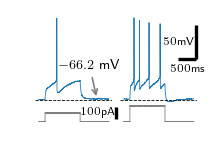

In [27]:
sample_rec = short_recs['5HT'][1]
time_slice = slice(20000, 40000)
baseline = sample_rec[0, time_slice.start:(time_slice.start + 500), :].mean()

steps_trace_spec = gs.GridSpec(
    2, 
    2, 
    height_ratios=[1, 0.2], 
    hspace=0,
    wspace=0.1,
    top=0.95,
    right=0.95,
    bottom=0.05,
    left=0.05
)

plt.figure(figsize=(1.5, 1))

plt.subplot(steps_trace_spec[0, 0])
plt.plot(sample_rec[:, time_slice, :].time_supp, sample_rec[0, time_slice, 9], color=colors['ser'])
plt.axhline(baseline, ls='--', color='k')
ylim = plt.ylim()
xlim = plt.xlim()
pltools.hide_border('a')
plt.annotate(
    '${:.1f}$ mV'.format(baseline), 
    (0.8, 0.05), 
    xytext=(0.7, 0.4),
    ha='center',
    xycoords=plt.gca().transAxes,
    textcoords=plt.gca().transAxes,
    fontsize=8,
    arrowprops={'arrowstyle': '->'}
)

plt.subplot(steps_trace_spec[1, 0])
plt.plot(sample_rec[:, time_slice, :].time_supp, sample_rec[1, time_slice, 9], color=colors['input'])
plt.xlim(xlim)
input_ylim = (-10, 140)
plt.ylim(input_ylim)
pltools.add_scalebar(y_units='pA', omit_x=True, anchor=(1.05, 0.1), linewidth=2)

plt.subplot(steps_trace_spec[0, 1])
plt.plot(sample_rec[:, time_slice, :].time_supp, sample_rec[0, time_slice, 15], color=colors['ser'])
plt.axhline(baseline, ls='--', color='k')
pltools.add_scalebar('ms', 'mV', x_size=500, bar_space=0, x_label_space=-0.05, anchor=(0.98, 0.5), linewidth=2)
plt.ylim(ylim)
plt.xlim(xlim)

plt.subplot(steps_trace_spec[1, 1])
plt.plot(sample_rec[:, time_slice, :].time_supp, sample_rec[1, time_slice, 15], color=colors['input'])
plt.xlim(xlim)
plt.ylim(input_ylim)
pltools.hide_border('a')

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, '5HT_current_steps.png'))
    plt.savefig(os.path.join(IMG_PATH, '5HT_current_steps.svg'))

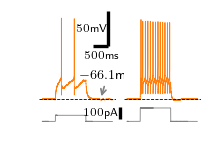

In [28]:
sample_rec = short_recs['GABA'][4]
time_slice = slice(27000, 50000)
baseline = sample_rec[0, time_slice.start:(time_slice.start + 500), :].mean()

steps_trace_spec = gs.GridSpec(
    2, 
    2, 
    height_ratios=[1, 0.2], 
    hspace=0,
    wspace=0.1,
    top=0.95,
    right=0.95,
    bottom=0.05,
    left=0.05
)

plt.figure(figsize=(1.5, 1))

plt.subplot(steps_trace_spec[0, 0])
plt.plot(sample_rec[:, time_slice, :].time_supp, sample_rec[0, time_slice, 10], color=colors['som'])
plt.axhline(baseline, ls='--', color='k')
ylim = plt.ylim()
xlim = plt.xlim()
pltools.add_scalebar('ms', 'mV', x_size=500, bar_space=0, x_label_space=-0.05, anchor=(0.9, 0.65), linewidth=2)

plt.annotate(
    '${:.1f}$mV'.format(baseline), 
    (0.8, 0.05), 
    xytext=(0.9, 0.3),
    ha='center',
    xycoords=plt.gca().transAxes,
    textcoords=plt.gca().transAxes,
    fontsize=8,
    arrowprops={'arrowstyle': '->'}
)

plt.subplot(steps_trace_spec[1, 0])
plt.plot(sample_rec[:, time_slice, :].time_supp, sample_rec[1, time_slice,10], color=colors['input'])
plt.xlim(xlim)
input_ylim = (-10, 140)
plt.ylim(input_ylim)
pltools.add_scalebar(y_units='pA', omit_x=True, anchor=(1.05, 0.1), linewidth=2)

plt.subplot(steps_trace_spec[0, 1])
plt.plot(sample_rec[:, time_slice, :].time_supp, sample_rec[0, time_slice, 16], color=colors['som'])
plt.axhline(baseline, ls='--', color='k')
pltools.hide_border('a')
plt.ylim(ylim)
plt.xlim(xlim)

plt.subplot(steps_trace_spec[1, 1])
plt.plot(sample_rec[:, time_slice, :].time_supp, sample_rec[1, time_slice, 16], color=colors['input'])
plt.xlim(xlim)
plt.ylim(input_ylim)
pltools.hide_border('a')

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'GABA_current_steps.png'))
    plt.savefig(os.path.join(IMG_PATH, 'GABA_current_steps.svg'))

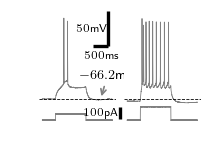

In [29]:
sample_rec = short_recs['mPFC'][4]
time_slice = slice(29000, 52000)
baseline = sample_rec[0, time_slice.start:(time_slice.start + 500), :].mean()

steps_trace_spec = gs.GridSpec(
    2, 
    2, 
    height_ratios=[1, 0.2], 
    hspace=0,
    wspace=0.1,
    top=0.95,
    right=0.95,
    bottom=0.05,
    left=0.05
)

plt.figure(figsize=(1.5, 1))

plt.subplot(steps_trace_spec[0, 0])
plt.plot(sample_rec[:, time_slice, :].time_supp, sample_rec[0, time_slice, 10], color=colors['pyr'])
plt.axhline(baseline, ls='--', color='k')
ylim = plt.ylim()
xlim = plt.xlim()
pltools.add_scalebar('ms', 'mV', x_size=500, bar_space=0, x_label_space=-0.05, anchor=(0.9, 0.65), linewidth=2)

plt.annotate(
    '${:.1f}$mV'.format(baseline), 
    (0.8, 0.05), 
    xytext=(0.9, 0.3),
    ha='center',
    xycoords=plt.gca().transAxes,
    textcoords=plt.gca().transAxes,
    fontsize=8,
    arrowprops={'arrowstyle': '->'}
)

plt.subplot(steps_trace_spec[1, 0])
plt.plot(sample_rec[:, time_slice, :].time_supp, sample_rec[1, time_slice,10], color=colors['input'])
plt.xlim(xlim)
input_ylim = (-10, 140)
plt.ylim(input_ylim)
pltools.add_scalebar(y_units='pA', omit_x=True, anchor=(1.05, 0.1), linewidth=2)

plt.subplot(steps_trace_spec[0, 1])
plt.plot(sample_rec[:, time_slice, :].time_supp, sample_rec[0, time_slice, 16], color=colors['pyr'])
plt.axhline(baseline, ls='--', color='k')
pltools.hide_border('a')
plt.ylim(ylim)
plt.xlim(xlim)

plt.subplot(steps_trace_spec[1, 1])
plt.plot(sample_rec[:, time_slice, :].time_supp, sample_rec[1, time_slice, 16], color=colors['input'])
plt.xlim(xlim)
plt.ylim(input_ylim)
pltools.hide_border('a')

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'mPFC_current_steps.png'))
    plt.savefig(os.path.join(IMG_PATH, 'mPFC_current_steps.svg'))

# Long current steps

## Export traces


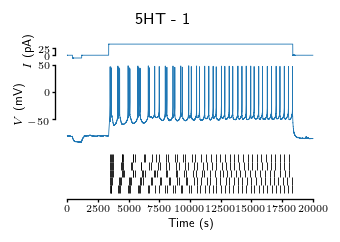

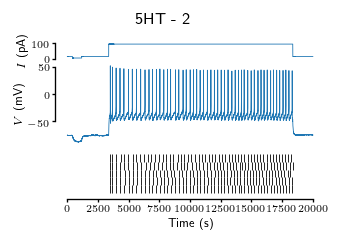

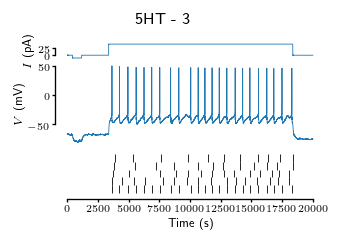

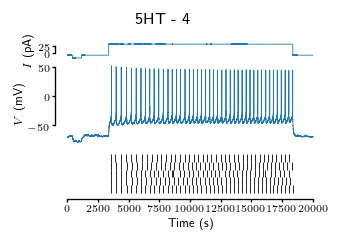

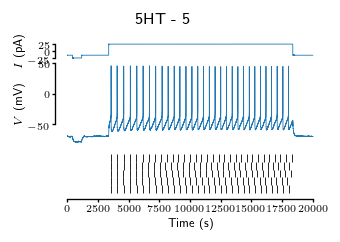

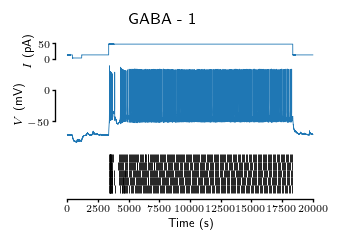

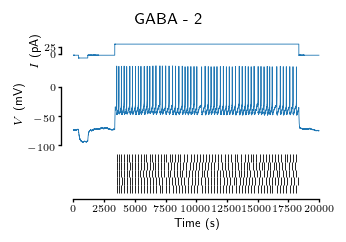

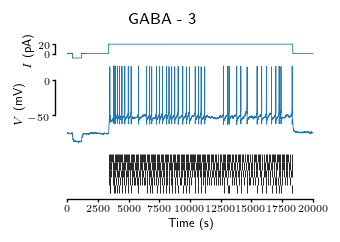

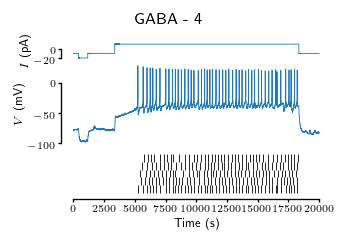

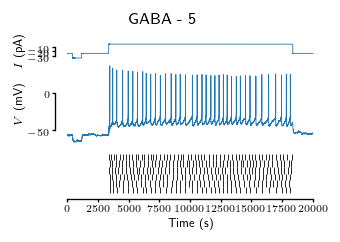

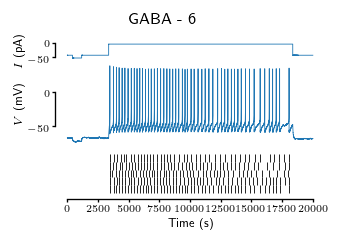

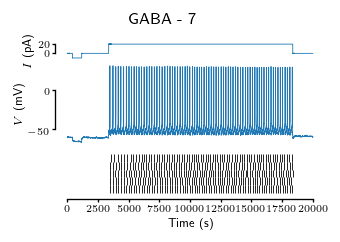

In [30]:
sample_sweep_no = 0

sample_trace_spec = gs.GridSpec(
    3, 1, height_ratios=[0.2, 1., 0.6], hspace=0.05, top=0.85, left=0.2, bottom=0.2, right=0.95
)

for cell_type in long_recs:
    for i, rec in enumerate(long_recs[cell_type]):
        
        plt.figure(frameon=False)
        
        plt.suptitle('{} - {}'.format(cell_type, i+1))
        
        plt.subplot(sample_trace_spec[0, :])
        plt.plot(rec.time_supp, rec[1, ...].mean(axis=1))
        plt.margins(0.05, 0.1)
        x_limits = plt.xlim()
        plt.xticks([])
        plt.ylabel('$I$ (pA)')
        sns.despine(bottom=True, trim=True, ax=plt.gca())
        
        plt.subplot(sample_trace_spec[1, :])
        plt.plot(rec.time_supp, rec[0, :, sample_sweep_no])
        plt.xlim(x_limits)
        plt.xticks([])
        plt.ylabel('$V$ (mV)')
        sns.despine(bottom=True, trim=True, ax=plt.gca())
        
        plt.subplot(sample_trace_spec[2, :])
        
        # Scrape spike times.
        spktimes = []
        for j in range(rec.shape[2]):
            tr_tmp = Trace(rec[0, :, j], rec[1, :, j], rec.shape[1] * rec.dt, rec.dt)
            tr_tmp.detectSpikes()
            spktimes.append(tr_tmp.getSpikeTimes())
        
        plt.eventplot(spktimes)
        plt.xlim(x_limits)
        plt.yticks([])
        plt.xlabel('Time (s)')
        sns.despine(left=True, trim=True, ax=plt.gca())
        
        
        if IMG_PATH is not None:
            plt.savefig(os.path.join(IMG_PATH, '{}_{}_long_current_steps.png'.format(cell_type, i+1)))
            
        plt.show()

del tr_tmp, spktimes, cell_type, rec